In [2]:
# cell 1
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "raw_analyst_ratings.csv", parse_dates=["date"])
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
# headline length
df['headline_len'] = df['headline'].astype(str).str.len()

# basic stats
headline_stats = df['headline_len'].describe()
missing_counts = df.isna().sum()

print("Headline length stats:\n", headline_stats)
print("\nMissing values per column:\n", missing_counts)


Headline length stats:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len, dtype: float64

Missing values per column:
 Unnamed: 0      0
headline        0
url             0
publisher       0
date            0
stock           0
headline_len    0
dtype: int64


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


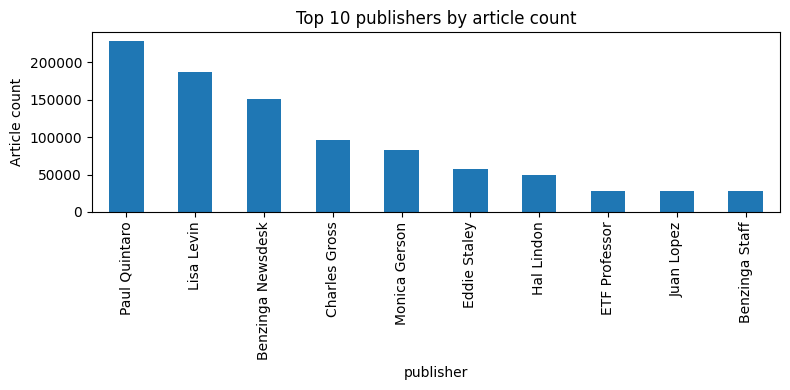

In [6]:
pub_counts = df['publisher'].value_counts()
print(pub_counts.head(20))

# plot top 10 publishers
pub_counts.head(10).plot.bar(figsize=(8,4))
plt.title("Top 10 publishers by article count")
plt.ylabel("Article count")
plt.tight_layout()
plt.show()

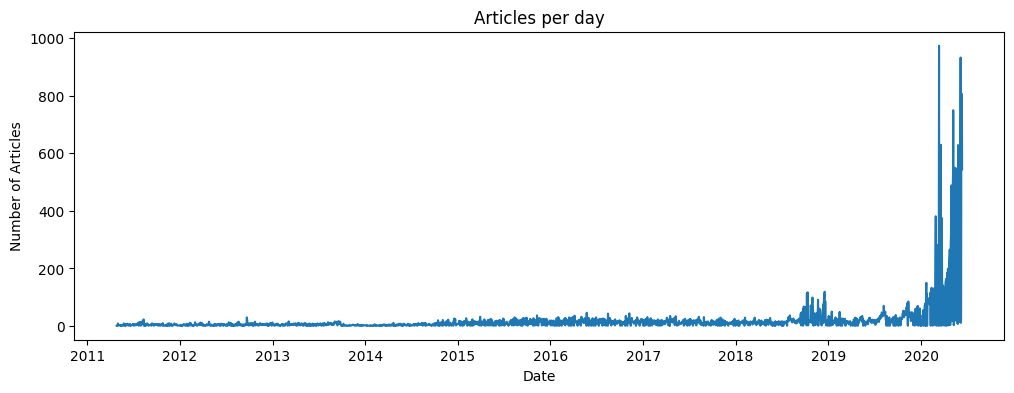

In [7]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_only'] = df['date'].dt.date
daily_counts = df.groupby('date_only').size().rename('n_articles')

daily_counts.plot(figsize=(12,4))
plt.title("Articles per day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


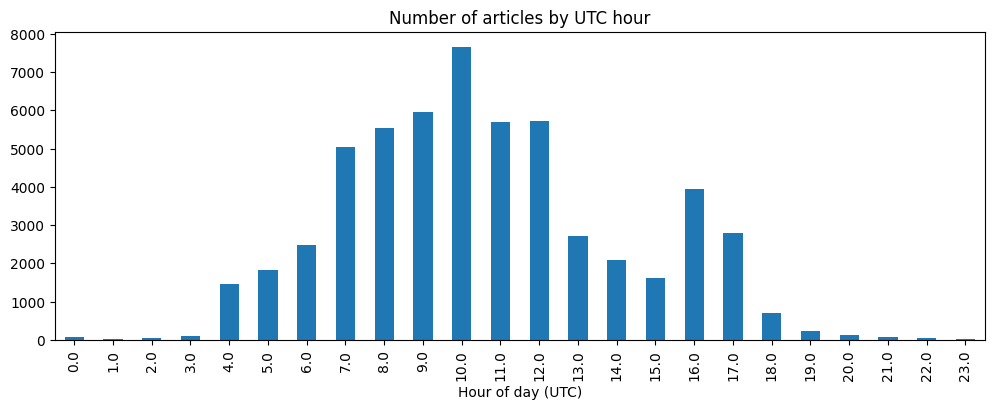

In [16]:
# convert to local time if necessary, here we use UTC
df['hour'] = df['date'].dt.hour
df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(12,4))
plt.title("Number of articles by UTC hour")
plt.xlabel("Hour of day (UTC)")
plt.show()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

texts = df['headline'].fillna("").astype(str).values

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(texts)

n_topics = 6
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

feature_names = tfidf.get_feature_names_out()

def display_topics(H, feature_names, n_top_words=8):
    topics = []
    for topic_idx, topic in enumerate(H):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append((topic_idx, top_features))
    return topics

topics = display_topics(H, feature_names)
for t in topics:
    print("Topic", t[0], ":", ", ".join(t[1]))


Topic 0 : 52 week, week, 52, stocks, hit 52, stocks hit, hit, week highs
Topic 1 : moving, stocks moving, session, market, stocks, pre market, pre, market session
Topic 2 : vs, est, eps, reports, sales, vs est, q4, estimate
Topic 3 : benzinga, benzinga upgrades, upgrades, downgrades, upgrades downgrades, benzinga downgrades, 2019, 2017
Topic 4 : earnings, earnings scheduled, scheduled, scheduled february, february, 2016, 2015, scheduled august
Topic 5 : target, price target, price, maintains, pt, raises, buy, 00


In [18]:
out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)
df.to_parquet(out_dir / "news_enriched.parquet")
